# Resnet Clustering

This notebook will use a pretrained (on imagenet) resnet 34 model and then perform K-Means clustering on this.

In [0]:
from fastai import *
import torch
from torch import nn
import imageio
from fastai.vision import *
import os
import torch.nn.functional as F
import numpy as np

In [112]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)
%cd "/content/drive/My Drive/automatic-asset-classification"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/automatic-asset-classification


In [0]:
np.random.seed(3333)
torch.manual_seed(3333)
image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"
size = 224
batchsize = 32

tfms = get_transforms(do_flip = True)
src = (ImageList.from_folder(image_path).split_by_rand_pct().label_from_folder())
data = (src.transform(tfms, size=size, resize_method=ResizeMethod.CROP)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats))
print("imported")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

imported


In [0]:
data

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

ImageDataBunch;

Train: LabelList (387 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
embankment,embankment,embankment,embankment,embankment
Path: /content/drive/My Drive/automatic-asset-classification/data/final_dataset;

Valid: LabelList (96 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
flood_wall,embankment,outfall,flood_wall,flood_wall
Path: /content/drive/My Drive/automatic-asset-classification/data/final_dataset;

Test: None

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

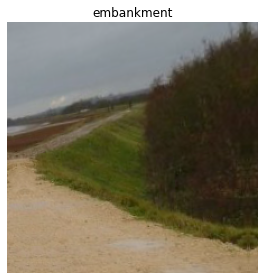

In [0]:
data.show_batch(rows=1)

## Clustering

Due to the other methods requiring training, this method will only use the validation set also for clustering.

In [0]:
class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class ResnetEncoder(nn.Module):
    def __init__(self):
        super(ResnetEncoder, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[:-2]))
        for param in resnet.parameters():
            param.requires_grad = False

        self.feature_extract = resnet

        self.ConcatPool2D = AdaptiveConcatPool2d()

    def forward(self,x):
        x = self.feature_extract(x)
        x = self.ConcatPool2D(x)
        return x.squeeze()


In [0]:
encoder = ResnetEncoder()
learn = Learner(data, encoder, metrics=error_rate, loss_func = F.mse_loss)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [0]:
preds, acts = learn.get_preds()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [0]:
len(preds)

96

In [0]:
acts

tensor([2, 0, 3, 2, 2, 2, 1, 0, 3, 4, 0, 4, 2, 1, 0, 0, 2, 0, 0, 0, 2, 2, 1, 4,
        3, 0, 2, 0, 3, 2, 0, 1, 3, 4, 4, 1, 0, 1, 2, 0, 0, 0, 0, 0, 3, 0, 3, 2,
        3, 0, 0, 1, 3, 3, 4, 0, 2, 3, 4, 0, 4, 1, 4, 0, 2, 3, 0, 2, 2, 2, 3, 4,
        0, 0, 0, 0, 2, 3, 3, 2, 4, 0, 2, 1, 1, 4, 3, 3, 0, 2, 3, 0, 3, 0, 4, 1])

In [0]:
cluster_data = preds.numpy()

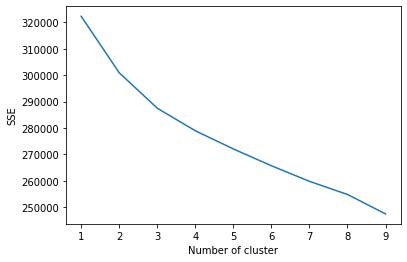

In [132]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(cluster_data)
    clusters = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [0]:
from sklearn.manifold import TSNE

In [0]:
X_embedded = TSNE(n_components=2).fit_transform(cluster_data)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

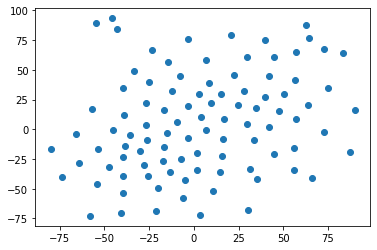

In [160]:
plt.scatter(X_embedded[:,0], X_embedded[:,1])

In [0]:
kmeans = KMeans(n_clusters=5, max_iter=1000).fit(cluster_data)
clusters = kmeans.labels_

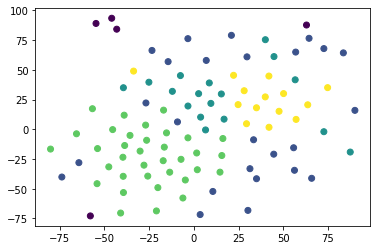

In [173]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clusters)

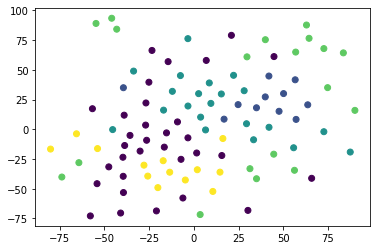

In [169]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=acts.numpy())

In [0]:
data.classes

['embankment', 'flood_gate', 'flood_wall', 'outfall', 'reservoir']

In [0]:
acts

tensor([2, 0, 3, 2, 2, 2, 1, 0, 3, 4, 0, 4, 2, 1, 0, 0, 2, 0, 0, 0, 2, 2, 1, 4,
        3, 0, 2, 0, 3, 2, 0, 1, 3, 4, 4, 1, 0, 1, 2, 0, 0, 0, 0, 0, 3, 0, 3, 2,
        3, 0, 0, 1, 3, 3, 4, 0, 2, 3, 4, 0, 4, 1, 4, 0, 2, 3, 0, 2, 2, 2, 3, 4,
        0, 0, 0, 0, 2, 3, 3, 2, 4, 0, 2, 1, 1, 4, 3, 3, 0, 2, 3, 0, 3, 0, 4, 1])

In [0]:
set(clusters)

{0, 1, 2, 3, 4, 5}

In [0]:
clusters_dict = {}
for i in range(6):
  clusters_dict[i] = []

In [0]:
for i in range(len(clusters)):
  ans = clusters[i]
  clusters_dict[ans].append(data.valid_ds[i][0])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

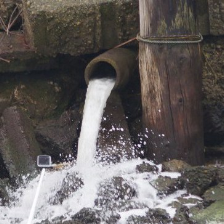

In [0]:
clusters_dict[3][4]

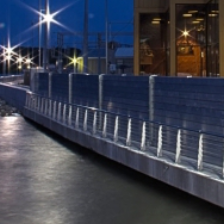

In [0]:
data.valid_ds[0][0]